# Dimensionality Reduction Utilities

> Flexible utilities for PCA, MDS, and biplots visualizations.

In [ ]:
#| default_exp dim_red_utility

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Union, Tuple, Any

# Machine learning
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.figure as mfigure
import matplotlib.axes as maxes

# Optional dependencies for label adjustment
try:
    from adjustText import adjust_text
    HAS_ADJUST_TEXT = True
except ImportError:
    HAS_ADJUST_TEXT = False

## The DimensionalityReductionPlotter Class
This class provides a unified framework for dimensionality reduction techniques, with a focus on visualization.

In [ ]:
#| export
class DimensionalityReductionPlotter:
    """
    A class for creating dimensionality reduction plots (PCA, MDS) from pandas DataFrames.
    
    Attributes:
    -----------
    in_df : pandas DataFrame
        Input data with features as rows and samples as columns
    top : int
        Number of top features to select based on mean
    color_dictionary : dict, optional
        Mapping from color names to display names
    model : object
        The fitted dimensionality reduction model (PCA, MDS, etc.)
    filtered_df : pandas DataFrame
        DataFrame after feature selection
    method : str
        The dimensionality reduction method ('pca' or 'mds')
    """
    
    def __init__(self, in_df: pd.DataFrame, top: int = 500, color_dictionary: Optional[Dict[str, str]] = None):
        """
        Initialize the DimensionalityReductionPlotter with data and settings.
        
        Parameters:
        -----------
        in_df : pandas DataFrame
            Input data with features as rows and samples as columns
        top : int
            Number of top features to select based on mean
        color_dictionary : dict, optional
            Mapping from color names to display names
        """
        self.in_df = in_df
        self.top = top
        self.color_dictionary = color_dictionary
        self.model = None
        self.filtered_df = None
        self.method = None
        self._preprocess_data()
    
    def _preprocess_data(self) -> None:
        """
        Preprocess the data by selecting top features.
        """
        # Feature selection based on mean
        sorted_mean = self.in_df.mean(axis=1).sort_values()
        select = sorted_mean.tail(self.top)
        self.filtered_df = self.in_df.loc[select.index.values]
    
    def fit(self, method: str = 'pca', n_components: int = 2, **kwargs) -> 'DimensionalityReductionPlotter':
        """
        Fit a dimensionality reduction model to the preprocessed data.
        
        Parameters:
        -----------
        method : str
            Dimensionality reduction method ('pca' or 'mds')
        n_components : int
            Number of components to compute
        **kwargs : dict
            Additional parameters to pass to the model constructor
            
        Returns:
        --------
        self : DimensionalityReductionPlotter
            Returns self for method chaining
        """
        self.method = method.lower()
        
        if self.method == 'pca':
            self.model = PCA(n_components=n_components, **kwargs)
            self.model.fit(self.filtered_df.T)  # Transpose so samples are rows
            print(f"Explained variance ratio: {self.model.explained_variance_ratio_}")
            
        elif self.method == 'mds':
            self.model = MDS(n_components=n_components, **kwargs)
            # MDS is fit during transform, so we don't call fit here
            
        else:
            raise ValueError(f"Unsupported method: {method}. Use 'pca' or 'mds'.")
            
        return self
    
    def transform_samples(self) -> pd.DataFrame:
        """
        Transform the samples using the fitted model.
        
        Returns:
        --------
        pd.DataFrame
            DataFrame containing the transformed samples
        """
        if self.model is None:
            raise ValueError("Model not fitted. Call 'fit' method first.")
            
        if self.method == 'pca':
            transformed = self.model.transform(self.filtered_df.T)
            
        elif self.method == 'mds':
            transformed = self.model.fit_transform(self.filtered_df.T)
            
        # Create DataFrame with transformed data
        col_prefix = 'pc' if self.method == 'pca' else 'dim'
        result_df = pd.DataFrame(
            transformed,
            index=self.filtered_df.columns,  # Sample names
            columns=[f'{col_prefix}_{i+1}' for i in range(transformed.shape[1])]
        )
        
        return result_df
    
    def get_feature_loadings(self) -> Optional[pd.DataFrame]:
        """
        Get feature loadings for the fitted model (PCA only).
        
        Returns:
        --------
        pd.DataFrame or None
            DataFrame containing the feature loadings for PCA, None for other methods
        """
        if self.model is None:
            raise ValueError("Model not fitted. Call 'fit' method first.")
            
        if self.method == 'pca':
            loadings = pd.DataFrame(
                self.model.components_.T,  # Transpose to get features as rows
                index=self.filtered_df.index,  # Feature names
                columns=[f'pc_{i+1}' for i in range(self.model.n_components_)]
            )
            return loadings
            
        else:
            print(f"Feature loadings not available for method: {self.method}")
            return None
    
    def _prepare_palette(self, data: pd.DataFrame, palette: Union[List, Dict, str]) -> pd.Series:
        """
        Prepare color palette for plotting.
        
        Parameters:
        -----------
        data : pd.DataFrame
            DataFrame to assign colors to
        palette : list, dict, or str
            Colors for different groups
            
        Returns:
        --------
        pd.Series
            Series with color assignments
        """
        if isinstance(palette, list):
            if len(palette) == len(data):
                return pd.Series(palette, index=data.index)
            else:
                raise ValueError(f"Length of palette list ({len(palette)}) must match number of items ({len(data)})")
                
        elif isinstance(palette, dict):
            # Create a Series with the same index as the data
            # Use map with the palette dictionary to assign colors
            color_series = pd.Series(index=data.index, dtype='object')
            for idx in data.index:
                if idx in palette:
                    color_series[idx] = palette[idx]
                else:
                    color_series[idx] = 'gray'
            return color_series
            
        else:
            # Assume it's a single color
            return pd.Series([palette] * len(data), index=data.index, dtype='object')
    
    def plot_samples(self, 
                   palette: Union[List, Dict, str], 
                   ax: Optional[maxes.Axes] = None, 
                   do_adjust_text: bool = False, 
                   title: Optional[str] = None,
                   point_size: int = 50,
                   alpha: float = 0.7) -> Tuple[mfigure.Figure, maxes.Axes, pd.DataFrame]:
        """
        Create a plot of the transformed samples.
        
        Parameters:
        -----------
        palette : list, dict, or str
            Colors for different sample groups
        ax : matplotlib.axes.Axes, optional
            Axis to plot on. If None, a new figure will be created.
        do_adjust_text : bool
            Whether to adjust text labels to avoid overlap
        title : str, optional
            Title of the plot. If None, a default title based on the method will be used.
        point_size : int
            Size of the scatter points
        alpha : float
            Transparency of the scatter points
            
        Returns:
        --------
        tuple
            (figure, axis, dataframe) - The matplotlib figure, axis, and DataFrame of transformed samples
        """
        if self.model is None:
            self.fit(method='pca')
        
        # Create default axis if none provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        else:
            fig = ax.figure
        
        # Get transformed data
        result_df = self.transform_samples()
        x_col, y_col = result_df.columns[0], result_df.columns[1]
        
        # Assign colors
        result_df['color'] = self._prepare_palette(result_df, palette)
        
        # Plot points
        groups = result_df['color'].unique()
        for color in groups:
            group_data = result_df[result_df['color'] == color]
            ax.scatter(
                x=group_data[x_col], 
                y=group_data[y_col], 
                c=color, 
                label=self.color_dictionary.get(color, color) if self.color_dictionary else color,
                s=point_size,
                alpha=alpha
            )
        
        # Add labels
        if do_adjust_text:
            try:
                from adjustText import adjust_text
                texts = []
                for i, (idx, row) in enumerate(result_df.iterrows()):
                    texts.append(
                        ax.text(row[x_col], row[y_col], idx)
                    )
                adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), ax=ax)
            except ImportError:
                print("Warning: adjustText package not found. Install with 'pip install adjustText'")
                for i, (idx, row) in enumerate(result_df.iterrows()):
                    ax.text(row[x_col], row[y_col], idx)
        
        # Set labels and title
        if title is None:
            title = f"{self.method.upper()} Plot"
        ax.set_title(title, size=14)
        
        if self.method == 'pca':
            ax.set_xlabel(f"PC1 ({self.model.explained_variance_ratio_[0]:.3f})", size=12)
            ax.set_ylabel(f"PC2 ({self.model.explained_variance_ratio_[1]:.3f})", size=12)
        else:
            ax.set_xlabel(x_col.upper(), size=12)
            ax.set_ylabel(y_col.upper(), size=12)
        
        # Add legend
        ax.legend(title='Groups', loc='center left', bbox_to_anchor=(1, 0.5))
        
        return fig, ax, result_df
    
    def plot_loadings(self, 
                    palette: Union[List, Dict, str], 
                    ax: Optional[maxes.Axes] = None, 
                    do_adjust_text: bool = False, 
                    title: Optional[str] = None,
                    arrow: bool = False, 
                    arrow_scale: float = 5,
                    alpha: float = 0.8,
                    biggest: Optional[int] = None) -> Tuple[mfigure.Figure, maxes.Axes, pd.DataFrame]:
        """
        Create a plot of feature loadings (PCA only).

        Parameters:
        -----------
        palette : list, dict, or str
            Colors for different feature groups
        ax : matplotlib.axes.Axes, optional
            Axis to plot on. If None, a new figure will be created.
        do_adjust_text : bool
            Whether to adjust text labels to avoid overlap
        title : str, optional
            Title of the plot. If None, a default title will be used.
        arrow : bool
            Whether to display loadings as arrows (True) or points (False)
        arrow_scale : float
            Scaling factor for arrows when arrow=True
        alpha : float
            Transparency of the points/arrows
        biggest : int or None
            If provided, only shows the top N highest and lowest loadings for each component.
            If None, shows all loadings.
            Default=None (show all)

        Returns:
        --------
        tuple
            (figure, axis, dataframe) - The matplotlib figure, axis, and DataFrame of feature loadings
        """
        if self.model is None:
            self.fit(method='pca')

        if self.method != 'pca':
            raise ValueError(f"Feature loadings plot not available for method: {self.method}")

        # Create default axis if none provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        else:
            fig = ax.figure

        # Get loadings
        loadings = self.get_feature_loadings()
        x_col, y_col = loadings.columns[0], loadings.columns[1]

        # Apply biggest filter if specified
        if biggest is not None and biggest > 0:
            # For PC1 (x-axis), get the top N highest and lowest loadings
            pc1_highest = loadings.nlargest(biggest, x_col).index.tolist()
            pc1_lowest = loadings.nsmallest(biggest, x_col).index.tolist()

            # For PC2 (y-axis), get the top N highest and lowest loadings
            pc2_highest = loadings.nlargest(biggest, y_col).index.tolist()
            pc2_lowest = loadings.nsmallest(biggest, y_col).index.tolist()

            # Combine the lists and remove duplicates
            selected_features = list(set(pc1_highest + pc1_lowest + pc2_highest + pc2_lowest))

            # Filter loadings to show only the selected features
            filtered_loadings = loadings.loc[selected_features]

            # Create a copy of the full loadings for return value
            full_loadings = loadings.copy()

            # Update loadings to the filtered version for plotting
            loadings = filtered_loadings

        # Assign colors
        loadings['color'] = self._prepare_palette(loadings, palette)

        # Plot loadings
        groups = loadings['color'].unique()

        if arrow:
            # Plot as arrows
            scale = arrow_scale

            for color in groups:
                group_data = loadings[loadings['color'] == color]

                for i, (idx, row) in enumerate(group_data.iterrows()):
                    ax.arrow(0, 0, 
                            row[x_col] * scale, row[y_col] * scale,
                            color=color, 
                            alpha=alpha,
                            width=0.003,
                            head_width=0.03)

                    # Always add labels when using 'biggest' filter
                    if biggest is not None or do_adjust_text:
                        # Add feature labels
                        label_x = row[x_col] * scale * 1.1
                        label_y = row[y_col] * scale * 1.1
                        ax.text(label_x, label_y, idx, color=color, ha='center', va='center', 
                                fontweight='bold' if biggest is not None else 'normal')

                # Add a proxy artist for the legend
                ax.plot([], [], color=color, 
                       label=self.color_dictionary.get(color, color) if self.color_dictionary else color,
                       marker='>', linestyle='-')

            # Add reference lines
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

        else:
            # Plot as points
            for color in groups:
                group_data = loadings[loadings['color'] == color]
                ax.scatter(
                    x=group_data[x_col], 
                    y=group_data[y_col], 
                    c=color, 
                    label=self.color_dictionary.get(color, color) if self.color_dictionary else color,
                    s=50,
                    alpha=alpha
                )

                # Always add labels when using 'biggest' filter
                if biggest is not None or do_adjust_text:
                    for i, (idx, row) in enumerate(group_data.iterrows()):
                        ax.text(row[x_col], row[y_col], idx, color=color, ha='center', va='bottom',
                                fontweight='bold' if biggest is not None else 'normal')

                # Use adjustText if requested and not using 'biggest' parameter
                elif do_adjust_text and biggest is None:
                    try:
                        from adjustText import adjust_text
                        texts = []
                        for i, (idx, row) in enumerate(loadings.iterrows()):
                            texts.append(
                                ax.text(row[x_col], row[y_col], idx)
                            )
                        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), ax=ax)
                    except ImportError:
                        print("Warning: adjustText package not found. Install with 'pip install adjustText'")
                        for i, (idx, row) in enumerate(loadings.iterrows()):
                            ax.text(row[x_col], row[y_col], idx)

        # Set labels and title
        if title is None:
            title = "PCA Loadings Plot"
        ax.set_title(title, size=14)
        ax.set_xlabel(f"PC1 ({self.model.explained_variance_ratio_[0]:.3f})", size=12)
        ax.set_ylabel(f"PC2 ({self.model.explained_variance_ratio_[1]:.3f})", size=12)

        # Add legend
        ax.legend(title='Groups', loc='center left', bbox_to_anchor=(1, 0.5))

        # Return full loadings rather than filtered set if 'biggest' was used
        return_loadings = full_loadings if 'full_loadings' in locals() else loadings

        return fig, ax, return_loadings
    
    def plot_biplot(self, 
                  feature_palette: Union[List, Dict, str], 
                  sample_palette: Union[List, Dict, str], 
                  ax: Optional[maxes.Axes] = None, 
                  do_adjust_text: bool = False, 
                  title: Optional[str] = None,
                  arrow_scale: float = 5, 
                  sample_alpha: float = 0.7, 
                  feature_alpha: float = 0.8,
                  sample_size: int = 50) -> Tuple[mfigure.Figure, maxes.Axes, Dict[str, pd.DataFrame]]:
        """
        Create a biplot showing both samples and feature loadings (PCA only).
        
        Parameters:
        -----------
        feature_palette : list, dict, or str
            Colors for different feature groups
        sample_palette : list, dict, or str
            Colors for different sample groups
        ax : matplotlib.axes.Axes, optional
            Axis to plot on. If None, a new figure will be created.
        do_adjust_text : bool
            Whether to adjust text labels to avoid overlap
        title : str, optional
            Title of the plot. If None, a default title will be used.
        arrow_scale : float
            Scaling factor for feature loading arrows
        sample_alpha : float
            Transparency of sample points
        feature_alpha : float
            Transparency of feature arrows
        sample_size : int
            Size of sample points
            
        Returns:
        --------
        tuple
            (figure, axis, data_dict) - The matplotlib figure, axis, and dictionary of DataFrames:
            The dictionary contains 'samples' and 'features' keys with their respective DataFrames
        """
        if self.model is None:
            self.fit(method='pca')
        
        if self.method != 'pca':
            raise ValueError(f"Biplot not available for method: {self.method}")
        
        # Create default axis if none provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        else:
            fig = ax.figure
        
        # 1. Get sample scores
        sample_df = self.transform_samples()
        x_col_sample, y_col_sample = sample_df.columns[0], sample_df.columns[1]
        
        # Assign colors to samples
        sample_df['color'] = self._prepare_palette(sample_df, sample_palette)
        
        # 2. Get feature loadings
        loadings_df = self.get_feature_loadings()
        x_col_loading, y_col_loading = loadings_df.columns[0], loadings_df.columns[1]
        
        # Assign colors to features
        loadings_df['color'] = self._prepare_palette(loadings_df, feature_palette)
        
        # Find scaling factor for arrows
        x_range = max(sample_df[x_col_sample]) - min(sample_df[x_col_sample])
        y_range = max(sample_df[y_col_sample]) - min(sample_df[y_col_sample])
        scale = arrow_scale * max(x_range, y_range) / max(abs(loadings_df[x_col_loading].max()),
                                                       abs(loadings_df[x_col_loading].min()),
                                                       abs(loadings_df[y_col_loading].max()),
                                                       abs(loadings_df[y_col_loading].min()))
        
        # Plot sample points
        sample_groups = sample_df['color'].unique()
        for color in sample_groups:
            group_data = sample_df[sample_df['color'] == color]
            ax.scatter(
                x=group_data[x_col_sample], 
                y=group_data[y_col_sample], 
                c=color, 
                label=f"Sample - {self.color_dictionary.get(color, color)}" if self.color_dictionary else f"Sample - {color}",
                s=sample_size,
                alpha=sample_alpha
            )
        
        # Plot feature loadings as arrows
        feature_groups = loadings_df['color'].unique()
        for color in feature_groups:
            group_data = loadings_df[loadings_df['color'] == color]
            
            for i, (idx, row) in enumerate(group_data.iterrows()):
                ax.arrow(0, 0, 
                        row[x_col_loading] * scale, row[y_col_loading] * scale,
                        color=color, 
                        alpha=feature_alpha,
                        width=0.003,
                        head_width=0.03)
                
                # Add feature labels
                label_x = row[x_col_loading] * scale * 1.1
                label_y = row[y_col_loading] * scale * 1.1
                ax.text(label_x, label_y, idx, color=color, ha='center', va='center')
            
            # Add a proxy artist for the legend
            ax.plot([], [], color=color, 
                   label=f"Feature - {self.color_dictionary.get(color, color)}" if self.color_dictionary else f"Feature - {color}",
                   marker='>', linestyle='-')
        
        # Add reference lines
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # Set labels and title
        if title is None:
            title = "PCA Biplot"
        ax.set_title(title, size=14)
        ax.set_xlabel(f"PC1 ({self.model.explained_variance_ratio_[0]:.3f})", size=12)
        ax.set_ylabel(f"PC2 ({self.model.explained_variance_ratio_[1]:.3f})", size=12)
        
        # Add legend
        ax.legend(title='Groups', loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Return both dataframes in a dictionary for easy access
        return fig, ax, {'samples': sample_df, 'features': loadings_df}
    
    def plot_explained_variance(self, 
                            ax: Optional[maxes.Axes] = None,
                            color: str = "#9B1D20",
                            cumulative: bool = True,
                            show_text: bool = True,
                            title: Optional[str] = None,
                            grid: bool = True) -> Tuple[mfigure.Figure, maxes.Axes, pd.DataFrame]:
        """
        Plot explained variance for PCA.
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axis to plot on. If None, a new figure will be created.
        color : str
            Color for the plot line and markers
        cumulative : bool
            Whether to plot cumulative explained variance (True) or individual variance per component (False)
        show_text : bool
            Whether to show text labels above each point
        title : str, optional
            Title of the plot. If None, a default title will be used.
        grid : bool
            Whether to show a grid on the plot
            
        Returns:
        --------
        tuple
            (figure, axis) - The matplotlib figure and axis objects
        """
        if self.model is None:
            self.fit(method='pca')
            
        if self.method != 'pca':
            raise ValueError(f"Explained variance plot not available for method: {self.method}")
            
        # Create default axis if none provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        else:
            fig = ax.figure
            
        # Get explained variance data
        exp_var = [val * 100 for val in self.model.explained_variance_ratio_]
        n_components = len(exp_var)
        plot_x = range(1, n_components + 1)
        
        if cumulative:
            # Cumulative explained variance
            plot_y = [sum(exp_var[:i+1]) for i in range(n_components)]
            ax.plot(plot_x, plot_y, marker="o", color=color, linewidth=2)
            
            # Add text labels
            if show_text:
                for x, y in zip(plot_x, plot_y):
                    ax.text(x, y + 1.5, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)
                    
            ax.set_ylabel("Cumulative Percentage of Explained Variance", size=12)
            default_title = "Cumulative Variance Explained per Principal Component"
            
        else:
            # Individual explained variance
            plot_y = exp_var
            ax.bar(plot_x, plot_y, color=color, alpha=0.7)
            
            # Add text labels
            if show_text:
                for x, y in zip(plot_x, plot_y):
                    ax.text(x, y + 0.5, f"{y:.1f}%", ha="center", va="bottom", fontsize=9)
                    
            ax.set_ylabel("Percentage of Explained Variance", size=12)
            default_title = "Variance Explained per Principal Component"
            
        # Set labels and title
        ax.set_xlabel("Principal Component", size=12)
        
        if title is None:
            title = default_title
        ax.set_title(title, loc="left", fontdict={"weight": "bold"}, y=1.06, size=14)
        
        # Set axis properties
        ax.set_xticks(plot_x)
        
        if cumulative:
            ax.set_yticks(range(0, 101, 5))
            ax.set_ylim(0, 100)
        
        if grid:
            ax.grid(axis="y", alpha=0.3)
            
        # Set layout
        plt.tight_layout()
        
        # Create a DataFrame with the explained variance data
        variance_df = pd.DataFrame({
            'component': range(1, n_components + 1),
            'explained_variance': exp_var,
            'cumulative_variance': [sum(exp_var[:i+1]) for i in range(n_components)]
        })
        
        return fig, ax, variance_df
    
    def get_results(self) -> Dict[str, Any]:
        """
        Return dimensionality reduction results for both samples and features.
        
        Returns:
        --------
        dict
            Dictionary containing the results
        """
        if self.model is None:
            self.fit()
            
        results = {
            'method': self.method,
            'sample_scores': self.transform_samples()
        }
        
        if self.method == 'pca':
            results['feature_loadings'] = self.get_feature_loadings()
            results['explained_variance_ratio'] = self.model.explained_variance_ratio_
            
        return results

In [ ]:
# Create synthetic data
np.random.seed(42)

# Number of samples and features
n_samples = 50
n_features = 100

# Generate random data with two distinct groups and some structure
data = np.random.randn(n_features, n_samples)

# Add some structure - make the first 30 features higher in first 25 samples
data[:30, :25] += 2

# Create a pandas DataFrame
feature_names = [f'feature_{i}' for i in range(n_features)]
sample_names = [f'sample_{i}' for i in range(n_samples)]
df = pd.DataFrame(data, index=feature_names, columns=sample_names)

# Create sample groups - mapping each sample to its color
sample_groups = {}
for i in range(n_samples):
    if i < 25:
        sample_groups[f'sample_{i}'] = 'red'
    else:
        sample_groups[f'sample_{i}'] = 'blue'

# Create feature groups - mapping each feature to its color
feature_groups = {}
for i in range(n_features):
    if i < 30:
        feature_groups[f'feature_{i}'] = 'green'
    elif i < 60:
        feature_groups[f'feature_{i}'] = 'purple'
    else:
        feature_groups[f'feature_{i}'] = 'orange'

# Create a color dictionary for nice labels
color_dict = {
    'red': 'Group A',
    'blue': 'Group B',
    'green': 'Gene Set 1',
    'purple': 'Gene Set 2',
    'orange': 'Gene Set 3'
}

# Preview the data
df.iloc[:5, :5]

,sample_0,sample_1,sample_2,sample_3,sample_4
feature_0,2.496714,1.861736,2.647689,3.523030,1.765847
feature_1,2.324084,1.614918,1.323078,2.611676,3.031000
feature_2,0.584629,1.579355,1.657285,1.197723,1.838714
feature_3,2.250493,2.346448,1.319975,2.232254,2.293072
feature_4,2.357787,2.560785,3.083051,3.053802,0.622331


Explained variance ratio: [0.42735199 0.04923835 0.04162556 0.0367032  0.0323377 ]


,pc_1,pc_2,pc_3,pc_4,pc_5
sample_0,4.833824,-0.524305,-1.099760,-1.171201,0.348957
sample_1,4.922518,-2.195776,-3.805798,-2.724017,-2.896950
sample_2,5.531237,2.777291,-0.293219,-2.368883,-0.057843
sample_3,7.213643,1.604138,-2.255550,-1.751800,2.053669
sample_4,5.982604,-0.348769,-0.019634,1.754475,0.805486


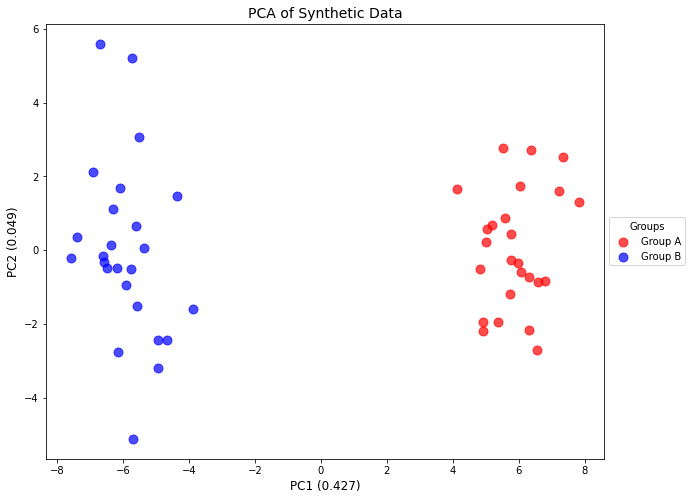

In [ ]:
# Create a plotter instance
plotter = DimensionalityReductionPlotter(
    in_df=df,
    top=50,  # Use top 50 features
    color_dictionary=color_dict
)

# Fit PCA and plot samples
plotter.fit(method='pca', n_components=5)
fig, ax, tmp_df = plotter.plot_samples(
    palette=sample_groups,
    point_size=80,
    do_adjust_text=False,
    title="PCA of Synthetic Data"
)
tmp_df.iloc[:5, :5]

,pc_1,pc_2,pc_3,pc_4,pc_5
feature_56,-0.009073,-0.075461,0.134354,-0.212345,-0.081578
feature_70,-0.037480,0.082879,-0.150355,-0.106533,0.243716
feature_99,-0.016096,0.101830,-0.366043,-0.102091,-0.031489
feature_71,-0.014748,0.209104,0.073929,-0.087332,0.088316
feature_94,0.039709,-0.044942,0.003832,-0.093297,0.106068


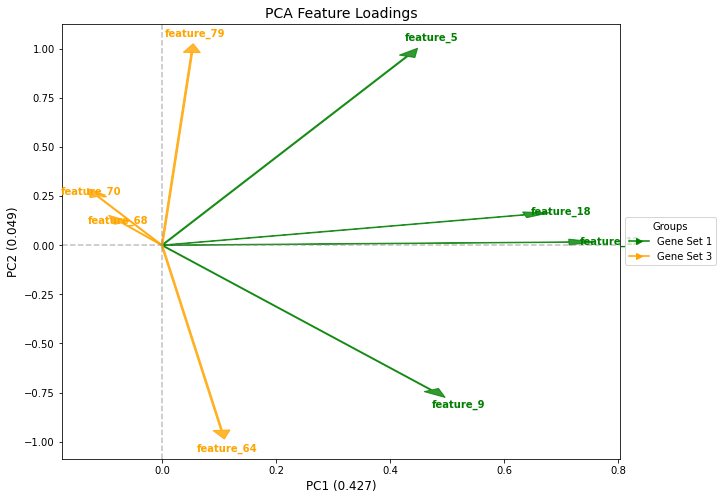

In [ ]:
# Plot the feature loadings as arrows
fig, ax, tmp_df  = plotter.plot_loadings(
    palette=feature_groups,
    arrow=True,
    arrow_scale=3,
    title="PCA Feature Loadings",
    biggest=2
)
tmp_df.iloc[:5, :5]

              pc_1      pc_2      pc_3      pc_4      pc_5
sample_0  4.833824 -0.524305 -1.099760 -1.171201  0.348957
sample_1  4.922518 -2.195776 -3.805798 -2.724017 -2.896950
sample_2  5.531237  2.777291 -0.293219 -2.368883 -0.057843
sample_3  7.213643  1.604138 -2.255550 -1.751800  2.053669
sample_4  5.982604 -0.348769 -0.019634  1.754475  0.805486
                pc_1      pc_2      pc_3      pc_4      pc_5
feature_56 -0.009073 -0.075461  0.134354 -0.212345 -0.081578
feature_70 -0.037480  0.082879 -0.150355 -0.106533  0.243716
feature_99 -0.016096  0.101830 -0.366043 -0.102091 -0.031489
feature_71 -0.014748  0.209104  0.073929 -0.087332  0.088316
feature_94  0.039709 -0.044942  0.003832 -0.093297  0.106068


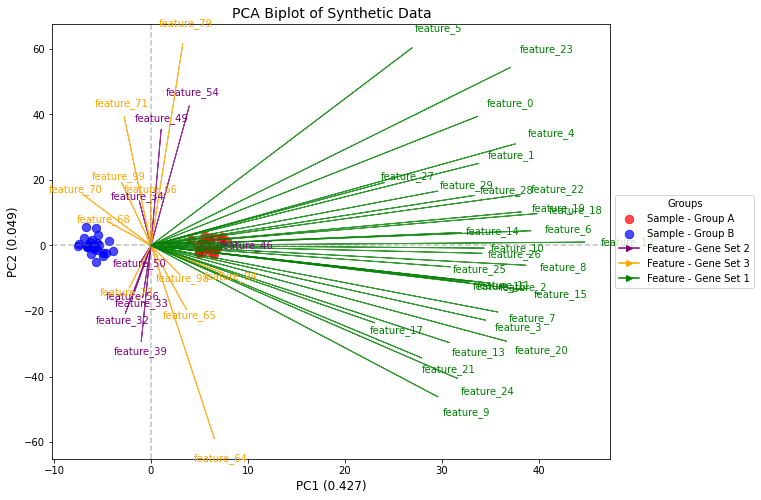

In [ ]:
# Create a biplot
fig, ax, tmp_df_dict = plotter.plot_biplot(
    feature_palette=feature_groups,
    sample_palette=sample_groups,
    arrow_scale=4,
    sample_size=70,
    title="PCA Biplot of Synthetic Data",
    #biggest=2
)
#tmp_df.iloc[:5, :5]
print(tmp_df_dict['samples'].iloc[:5, :5])
print(tmp_df_dict['features'].iloc[:5, :5])

,component,explained_variance,cumulative_variance
0,1,42.735199,42.735199
1,2,4.923835,47.659034
2,3,4.162556,51.821590
3,4,3.670320,55.491911
4,5,3.233770,58.725681


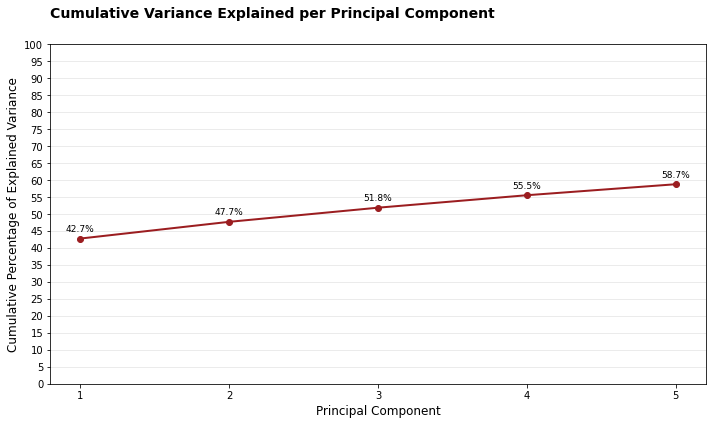

In [ ]:
# Cumulative explained variance
fig, ax, tmp_df = plotter.plot_explained_variance(
    cumulative=True,
    color="#9B1D20"
)
tmp_df.head()

,component,explained_variance,cumulative_variance
0,1,42.735199,42.735199
1,2,4.923835,47.659034
2,3,4.162556,51.821590
3,4,3.670320,55.491911
4,5,3.233770,58.725681


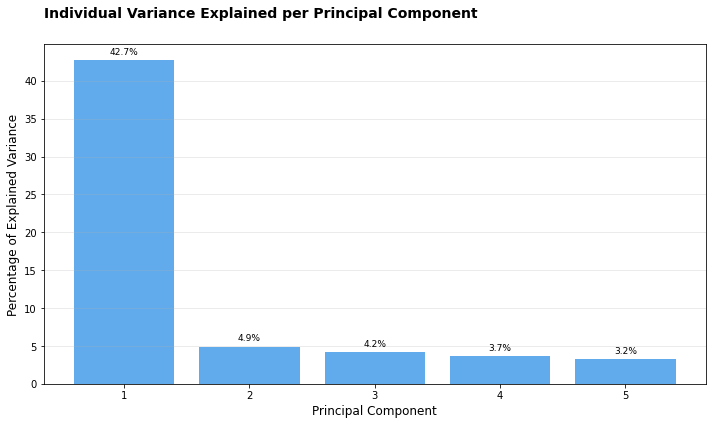

In [ ]:
# Individual explained variance
fig, ax, tmp_df = plotter.plot_explained_variance(
    cumulative=False,
    color="#1E88E5",
    title="Individual Variance Explained per Principal Component"
)
tmp_df.head()

/Users/MTinti/miniconda3/envs/work3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


,dim_1,dim_2,color
sample_0,-2.463140,4.037141,red
sample_1,-8.969954,3.636025,red
sample_2,0.072362,6.270072,red
sample_3,-3.341935,10.120119,red
sample_4,-3.417970,6.328873,red


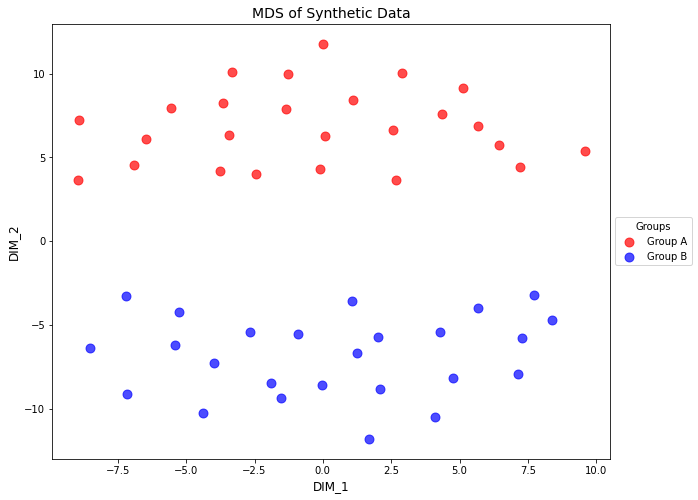

In [ ]:
# Switch to MDS
plotter.fit(method='mds', metric=True, random_state=42)

# Plot MDS results
fig, ax, tmp_df = plotter.plot_samples(
    palette=sample_groups,
    point_size=80,
    title="MDS of Synthetic Data"
)
tmp_df.head()

In [ ]:
#| export
def create_dim_reduction_dashboard(in_df, 
                                 sample_palette, 
                                 feature_palette,
                                 top=50, 
                                 color_dictionary=None,
                                 n_components=5,
                                 title="Dimensionality Reduction Dashboard",
                                 figsize=(16, 12)):
    """
    Create a comprehensive 2x2 dashboard of dimensionality reduction visualizations.
    
    Parameters:
    -----------
    in_df : pandas DataFrame
        Input data with features as rows and samples as columns
    sample_palette : dict
        Mapping from sample names to colors
    feature_palette : dict
        Mapping from feature names to colors
    top : int
        Number of top features to select based on mean
    color_dictionary : dict, optional
        Mapping from color names to display names
    n_components : int
        Number of principal components to calculate
    title : str
        Title for the overall figure
    figsize : tuple
        Figure size (width, height) in inches
        
    Returns:
    --------
    tuple
        (figure, axes, data_dict) - The matplotlib figure, axes, and dictionary containing 
        DataFrames for all the generated plots, with keys 'pca_samples', 'mds_samples', 
        'pca_loadings', and 'explained_variance'
    """
    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16, y=0.98)
    
    # Add some space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Create plotter instance
    plotter = DimensionalityReductionPlotter(
        in_df=in_df,
        top=top,
        color_dictionary=color_dictionary
    )
    
    # Dictionary to store all DataFrames
    data_dict = {}
    
    # 1. PCA Plot (top left)
    plotter.fit(method='pca', n_components=n_components)
    _, _, pca_df = plotter.plot_samples(
        palette=sample_palette,
        ax=axes[0, 0],
        title="PCA Sample Plot",
        point_size=70
    )
    data_dict['pca_samples'] = pca_df
    
    # 2. MDS Plot (top right)
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.manifold._mds")
        plotter.fit(method='mds', n_components=2, random_state=42, dissimilarity='euclidean')
    _, _, mds_df = plotter.plot_samples(
        palette=sample_palette,
        ax=axes[0, 1],
        title="MDS Sample Plot",
        point_size=70
    )
    data_dict['mds_samples'] = mds_df
    
    # Switch back to PCA for the bottom plots
    plotter.fit(method='pca', n_components=n_components)
    
    # 3. PCA Loadings (bottom left)
    _, _, loadings_df = plotter.plot_loadings(
        palette=feature_palette,
        ax=axes[1, 0],
        title="PCA Feature Loadings",
        arrow=True,
        arrow_scale=3
    )
    data_dict['pca_loadings'] = loadings_df
    
    # 4. Explained Variance (bottom right)
    _, _, variance_df = plotter.plot_explained_variance(
        ax=axes[1, 1],
        title="Cumulative Explained Variance",
        color="#9B1D20"
    )
    data_dict['explained_variance'] = variance_df
    
    # Add overall caption
    plt.figtext(0.5, 0.01, 
                f"Analysis of {in_df.shape[1]} samples and top {top} features",
                ha="center", fontsize=12, style='italic')
    
    return fig, axes, data_dict

Explained variance ratio: [0.42735199 0.04923835 0.04162556 0.0367032  0.0323377 ]
Explained variance ratio: [0.42735199 0.04923835 0.04162556 0.0367032  0.0323377 ]


/Users/MTinti/miniconda3/envs/work3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


Available DataFrames in results_dict:
- pca_samples: (50, 6)
- mds_samples: (50, 3)
- pca_loadings: (50, 6)
- explained_variance: (5, 3)

Examined variance explained by first 3 components:
   component  explained_variance  cumulative_variance
0          1           42.735199            42.735199
1          2            4.923835            47.659034
2          3            4.162556            51.821590


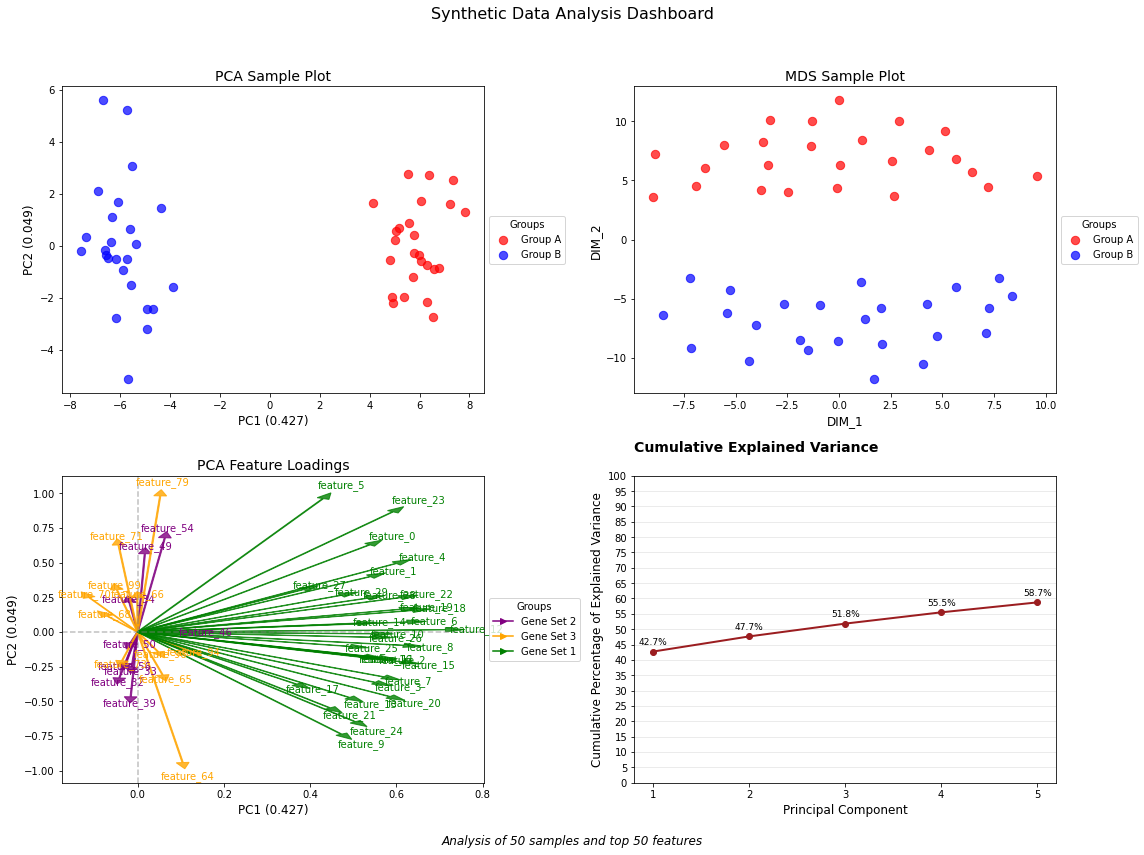

In [ ]:
# Create the dashboard
fig, axes, results_dict = create_dim_reduction_dashboard(
    in_df=df,
    sample_palette=sample_groups,
    feature_palette=feature_groups,
    top=50,
    color_dictionary=color_dict,
    title="Synthetic Data Analysis Dashboard"
)

# Fine tune the figure if needed
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle and caption

# Now you have access to all the DataFrames for further analysis
print("Available DataFrames in results_dict:")
for key in results_dict:
    print(f"- {key}: {results_dict[key].shape}")
    
# Example of further analysis with the returned DataFrames
print("\nExamined variance explained by first 3 components:")
print(results_dict['explained_variance'].head(3))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()